In [34]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

import os
import sys

notebook_path = os.path.abspath(".")
sys.path.append(os.path.abspath(os.path.join(notebook_path, '..', 'src')))

from limpieza import limpia, transforma_ML
import encoding_func

In [35]:
with open(f"../bin/cambio_automatico_encoder.pickle", "rb") as file:
    cambio_automatico_encoder = pickle.load(file)
    
with open(f"../bin/carroceria_encoder.pickle", "rb") as file:
    carroceria_encoder = pickle.load(file)

with open(f"../bin/certificado_encoder.pickle", "rb") as file:
    certificado_encoder = pickle.load(file)

with open(f"../bin/color_encoder.pickle", "rb") as file:
    color_encoder = pickle.load(file)

with open(f"../bin/combustible_encoder.pickle", "rb") as file:
    combustible_encoder = pickle.load(file)

with open(f"../bin/distintivo_ambiental_encoder.pickle", "rb") as file:
    distintivo_ambiental_encoder = pickle.load(file)

with open(f"../bin/vendedor_profesional_encoder.pickle", "rb") as file:
    vendedor_profesional_encoder = pickle.load(file)
    
with open(f"../bin/peninsula_y_baleares_encoder.pickle", "rb") as file:
    peninsula_y_baleares_encoder = pickle.load(file)

with open(f"../bin/marca_sola_precio_encoder.pickle", "rb") as file:
    marca_sola_precio_encoder = pickle.load(file)

with open(f"../bin/potencia_segmentado_precio_encoder.pickle", "rb") as file:
    potencia_segmentado_precio_encoder = pickle.load(file)

with open(f"../bin/provincia_precio_encoder.pickle", "rb") as file:
    provincia_precio_encoder = pickle.load(file)

with open(f"../bin/comunidad_precio_encoder.pickle", "rb") as file:
    comunidad_precio_encoder = pickle.load(file)


In [ ]:
TARGET = "precio"
df = limpia.tratamiento_nans("../data/coches_consolidado_limpio.csv")
df = transforma_ML.normalizar(df, ["kilometraje", "potencia", "precio"])
df_modelo = df.drop(columns=["modelo_titulo", "referencia", "url", "ruta_imagen", "fecha_extraccion", "nombre_vendedor", "garantia","potencia_segmentado","comunidad"])
#df_modelo = df[['kilometraje', 'cambio_automatico', 'potencia', 'marca_sola', 'anio_matricula']] #cambiar anio_matricula por antiguedad

df_modelo["combustible"] = combustible_encoder.transform(df_modelo["combustible"].astype(str))
df_modelo["carroceria"] = carroceria_encoder.transform(df_modelo["carroceria"].astype(str))
df_modelo["color"] = color_encoder.transform(df_modelo["color"].astype(str))
df_modelo["distintivo_ambiental"] = distintivo_ambiental_encoder.transform(df_modelo["distintivo_ambiental"].astype(str))

df_modelo["cambio_automatico"] = cambio_automatico_encoder.transform(df_modelo[["cambio_automatico"]])
df_modelo["certificado"] = certificado_encoder.transform(df_modelo[["certificado"]])
df_modelo["peninsula_y_baleares"] = peninsula_y_baleares_encoder.transform(df_modelo[["peninsula_y_baleares"]])
df_modelo["vendedor_profesional"] = vendedor_profesional_encoder.transform(df_modelo[["vendedor_profesional"]])


X_train, X_test, y_train, y_test = encoding_func.dividir_dataframe(df_modelo, TARGET, test_size=0.2, random_state=42)

X_train["marca_sola"] = marca_sola_precio_encoder.transform(X_train["marca_sola"])
X_test["marca_sola"] = marca_sola_precio_encoder.transform(X_test["marca_sola"])

#***********************************************************
X_train["provincia"] = provincia_precio_encoder.transform(X_train["provincia"])
X_test["provincia"] = provincia_precio_encoder.transform(X_test["provincia"])

feature_names = np.array(X_train.columns)

clf = ExtraTreesRegressor(n_estimators = 200, random_state=42)
clf = clf.fit(X_train, y_train)

clf.feature_importances_

array([1.63693798e-02, 7.86480898e-02, 1.49475952e-02, 1.28540554e-02,
       9.82065072e-02, 1.37253011e-02, 2.41461902e-02, 4.74068870e-01,
       1.58941690e-02, 2.29315724e-02, 1.27762647e-06, 3.51166741e-02,
       1.63337922e-02, 1.00863707e-01, 1.47652316e-02, 5.99729993e-02,
       1.15458885e-03])

In [48]:
model = SelectFromModel(estimator    = clf,
                        prefit       = True,
                        threshold    = None,
                        max_features = 10)

X_fs = model.transform(X_train)
X_fs.shape

e:\hackABoss\pfb-coches\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(11605, 5)

In [49]:
feature_names[model.get_support()]

array(['kilometraje', 'cambio_automatico', 'potencia', 'marca_sola',
       'anio_matricula'], dtype=object)

### Feature impotrance cumsum based selection

In [41]:
max_importance = 0.8 # Suma de importances a lograr

# Importances
importances = clf.feature_importances_

# Suma acumulativa de las importances ordenadas de mayor a menor
indices = np.argsort(importances)[::-1]
cumsum = np.cumsum(importances[indices])

# Filtrado de las mejores columnas que sumen hasta el max_impotrance
n_features = np.argmax(cumsum >= max_importance) + 1
selected_indices = indices[:n_features]

# Columnas
feature_names[selected_indices]

array(['potencia', 'marca_sola', 'cambio_automatico', 'kilometraje',
       'anio_matricula'], dtype=object)

<Axes: >

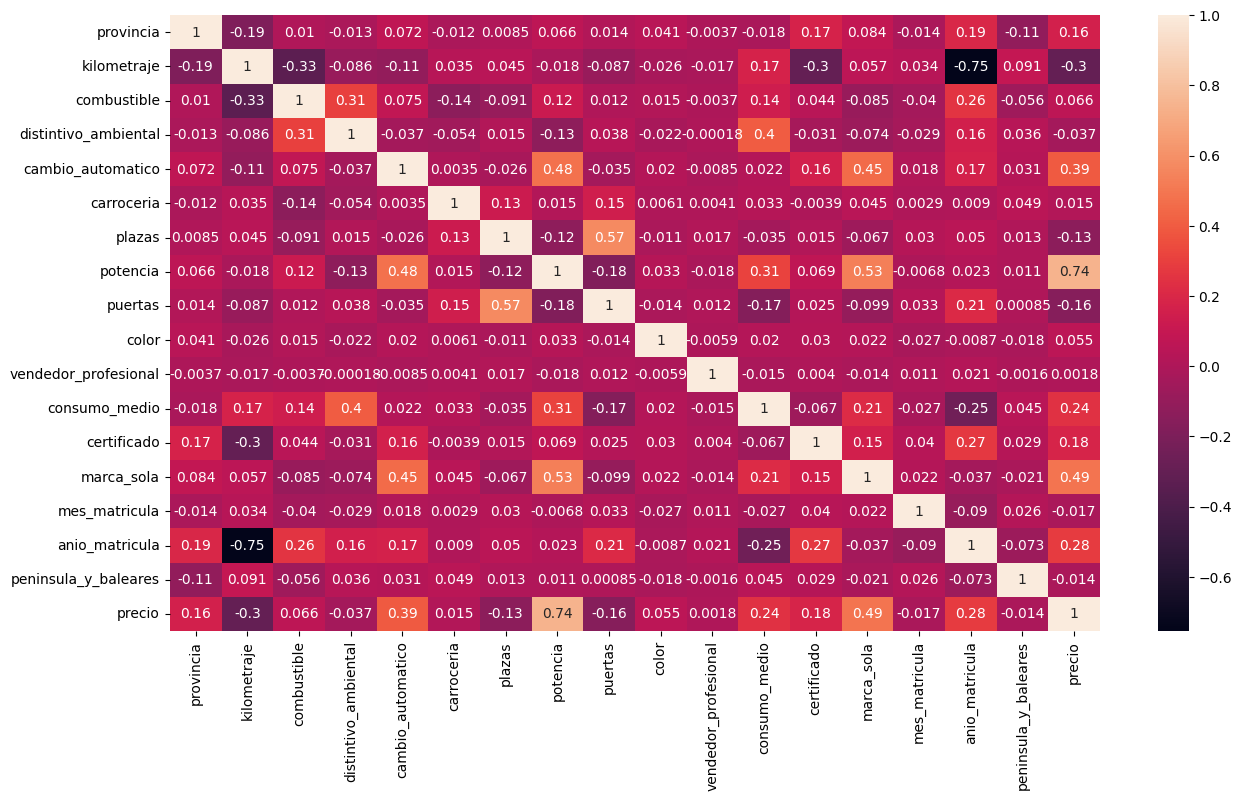

In [42]:
fig, ax = plt.subplots(figsize = (15, 8))

X_y = pd.concat([X_train, y_train], axis = 1)
sns.heatmap(X_y.corr(), annot = True)

<Axes: >

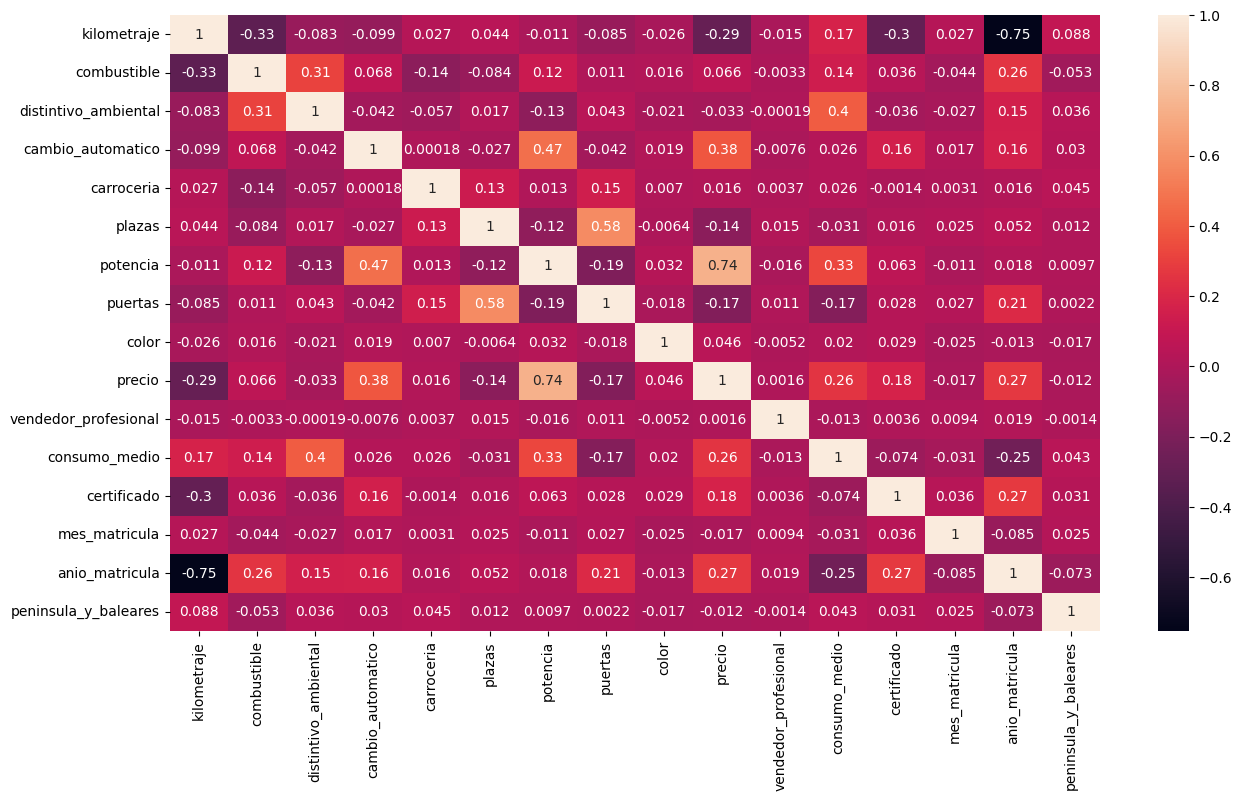

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.heatmap(df_modelo._get_numeric_data().corr(), annot = True)

In [ ]:
# Guardar df con columnas del feature selection en pickle